In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import src.data.utils as utils
import os

In [ ]:
# !pip install outlier-utils

## Load Data

In [2]:
df = utils.load_dataset(0) # loading cleaned dataset

Loaded dataset: \cleaned_data\additional_data_cleaned.parquet


In [3]:
#os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/")
data = pd.read_parquet("data/cleaned_data/interpolated_TL.parquet")
data.head()

,id,timeindex,torqueactual
0,6640-101753|2021-03-01_10:37:33,0.01,-0.015558
1,6640-101753|2021-03-01_10:37:33,0.02,0.079586
2,6640-101753|2021-03-01_10:37:33,0.03,0.035336
3,6640-101753|2021-03-01_10:37:33,0.04,0.125822
4,6640-101753|2021-03-01_10:37:33,0.05,-0.012471


## Functions

In [2]:
def modify_df(given_df):
    given_df['robot_type'] = given_df['id'].str[:4] # save only the robot id ABCD
    given_df['robot'] = given_df['id'].str[:11]
    return given_df

def data_of_robot(given_df, given_robot_id, parameter_type, series_type):
    # parameter_type: ["motorposition", "speedsetpoint", "torqueactual", "torquefeedforward"]
    # series_type: ["Ta", "Tl"]
    #  -> "Ta": corresponds to a predetermined sequence of movements lasting 3.48 seconds
    #  -> "Tl": robot arm is moved describing the programmed set of moves.
    
    temp_df_subset = given_df[(given_df['robot'] == given_robot_id) & (given_df["type"] == series_type)]
    all_sessions = list(temp_df_subset["id"].unique())
    print("Number of sessions: ", len(all_sessions))
    
    for session in all_sessions:
        current_df_subset = temp_df_subset[temp_df_subset["id"] == session]
        plt.plot(current_df_subset['timeindex'], current_df_subset[parameter_type], marker = 'o', markersize = 1)
    
    plt.xlabel('timeindex')
    plt.ylabel(f'{given_robot_id}')
    plt.show()
    
def get_all_robots_of_specific_id(given_df, given_robot_type):
    # ex: given "6640" returns ['6640-102123', '6640-102138', ..., '6640-108019'
    # possible ids: [6640, 6700, 7600]
    given_df = given_df[given_df['robot_type'] == given_robot_type]
    return list(given_df['robot'].unique())

def get_all_robots_of_main_id(given_df):
    return list(given_df['robot_type'].unique())

def get_all_robots_of_specific_id_sessions(given_df, given_robot_id, given_series_type):
    temp_df_subset = given_df[(given_df['robot'] == given_robot_id) & (given_df["type"] == given_series_type)]
    return list(temp_df_subset["id"].unique())

## Pre-processing

In [5]:
modified_df = modify_df(df)

In [6]:
for temp_id in get_all_robots_of_main_id(modified_df):
    print("Current main id: ", temp_id)
    
    for temp_specific_id in get_all_robots_of_specific_id(modified_df, temp_id):
        print("     Current specific id: ", temp_specific_id)
        
    print()

Current main id:  7600
     Current specific id:  7600-100440
     Current specific id:  7600-100498



In [7]:
modified_df.head(10)

,axisnumber,id,manipulator,motorposition,speedsetpoint,timeindex,torqueactual,torquefeedforward,type,date,robot_type,robot
6912,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,-0.000000,0.009,0.053306,0.0,TL,2022-11-16,7600,7600-100440
6913,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,0.380452,0.023,-0.093410,0.0,TL,2022-11-16,7600,7600-100440
6914,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,0.380452,0.033,-0.087937,0.0,TL,2022-11-16,7600,7600-100440
6915,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,-0.380452,0.042,0.044531,0.0,TL,2022-11-16,7600,7600-100440
6916,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,-0.000000,0.051,-0.095396,0.0,TL,2022-11-16,7600,7600-100440
6917,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.00,-0.000000,0.060,0.217431,0.0,TL,2022-11-16,7600,7600-100440
6918,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.01,-0.000000,0.069,0.818732,0.0,TL,2022-11-16,7600,7600-100440
6919,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.03,0.760903,0.078,0.752879,0.0,TL,2022-11-16,7600,7600-100440
6920,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.05,0.380452,0.087,1.142800,0.0,TL,2022-11-16,7600,7600-100440
6921,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.09,1.141350,0.096,1.928110,0.0,TL,2022-11-16,7600,7600-100440


In [8]:
# data_of_robot(modified_df, '7600-100440', 'motorposition', 'Ta')

## Baseline Algo

In [3]:
from tqdm import tqdm

def add_mean_and_std_into_df(given_df):
    """
    creating dict where -> dict[specific_robot_id][series_type][parameter_type] = [mean & standart_deviation]
    """
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # to avoid warnings
    new_df = given_df.copy(deep=True) # first deep cloning to avoid changes on the original df

    # first getting all the parameter values
    all_main_robot_ids = list(new_df['robot_type'].unique())
    all_specific_robot_ids = []
    all_series_type = list(new_df['type'].unique())
    all_parameter_type = ["motorposition", "speedsetpoint", "torqueactual", "torquefeedforward"]
    all_time_index_ids = []
    
    for robot_type in all_main_robot_ids:
        all_specific_robot_ids = all_specific_robot_ids + get_all_robots_of_specific_id(new_df, robot_type)
    
    for specific_robot_id in all_specific_robot_ids:
        temp_df_subset = new_df[(new_df['robot'] == specific_robot_id)]
        all_time_index_ids = all_time_index_ids + list(temp_df_subset["id"].unique())


    # now it's time to calculate the mean and std of each specific robot id
    saved_information = {}
    
    # go through each robot id
    for specific_robot_id in all_specific_robot_ids:
        print("Current robot id: ", specific_robot_id)

        time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if specific_robot_id in time_index]
        # temp_new_df_subset = new_df[(new_df['robot'] == specific_robot_id)]
        # time_index_ids_of_specific_robot = list(temp_new_df_subset["timeindex"])


        df_of_robot = new_df[(new_df['robot'] == specific_robot_id)]
        
        for series_type in tqdm(all_series_type):
            df_of_robot_series = df_of_robot[(df_of_robot['type'] == series_type)]

            for param_type in all_parameter_type:
                df_of_robot_series_param = pd.DataFrame()
                df_of_robot_series_param["id"] = df_of_robot_series["id"]
                df_of_robot_series_param[param_type] = df_of_robot_series[param_type]

                saved_lists = []
                
                # the most time consuming part
                size_of_each_time_series = []
                for t_index in time_index_ids_of_specific_robot:
                    saved_lists.append(list(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][param_type]))
                    size_of_each_time_series.append(len(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][param_type]))
                
                # because we have time-indexes with different sizes, need to set all into equal size
                max_length = max(len(arr) for arr in saved_lists)
                padded_arrays = np.array([np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in saved_lists])

                # save data
                saved_information[specific_robot_id + "_" + series_type + "_" + param_type + "_avg" ] = np.average(padded_arrays, axis=0)
                saved_information[specific_robot_id + "_" + series_type + "_" + param_type + "_std" ] = np.std(padded_arrays, axis=0)
                    
                print("On info: ", specific_robot_id + "_" + series_type + "_" + param_type + "_avg")
                print("Actual size: ", np.average(size_of_each_time_series))
                print("The size of the saved list: ", len(np.average(padded_arrays, axis=0)))
                
        print()
                    
    return saved_information 

def get_info_of_all_time_series_specific(given_df, given_robot_id, given_series_type, given_param):
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # to avoid warnings
    new_df = given_df.copy(deep=True) # first deep cloning to avoid changes on the original df

    # getting all time-series of the robot id    
    temp_df_subset = new_df[(new_df['robot'] == given_robot_id)]
    all_time_index_ids = list(temp_df_subset["id"].unique())

    saved_information = {}
    
    print("Working on robot id: ", given_robot_id)
    time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if given_robot_id in time_index]
    df_of_robot_specific = new_df[(new_df['robot'] == given_robot_id) & (new_df["type"] == given_series_type)]
    
    # to reduce the data it works on
    df_of_robot_series_param = pd.DataFrame()
    df_of_robot_series_param["id"] = df_of_robot_specific["id"]
    df_of_robot_series_param[given_param] = df_of_robot_specific[given_param]

    saved_lists = []
    for t_index in time_index_ids_of_specific_robot:
        saved_lists.append(list(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][given_param]))
                    
    return saved_lists 

import scipy.stats as st
def calculate_prob_list(given_robot_name, given_series_type, given_param, given_data, given_mean_and_std_info):
    prob_list = []
    saved_mean = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_avg")
    saved_std = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_std")
    
    for i in range(len(given_data)):
        z = (np.abs(given_data[i] - saved_mean[i])) / saved_std[i]
        p_value = st.norm.sf(abs(z))*2 # 2-sided test
        # p_value = st.norm.cdf(z) # gives the percentage
        prob_list.append(p_value) # TODO: add additional check for 0 and so on?
            
    return prob_list
        
def detect_anomaly_via_z(given_robot_name, given_series_type, given_param, given_data, given_mean_and_std_info):
    temp_z_list = []

    saved_mean = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_avg")
    saved_std = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_std")
    
    smaller_one = len(saved_mean)
    if len(saved_mean) > len(given_data):
        smaller_one = len(given_data)

    for i in range(smaller_one):
        temp_z_list.append((np.abs(given_data[i] - saved_mean[i])) / saved_std[i])
            
    max_z_value = max(temp_z_list)
    
    if len(saved_mean) != len(given_data):
        print("ERROR: The size of the data is not equal to the saved mean/std data")
        print("The size of the data: ", len(given_data))
        print("The size of the saved mean: ", len(saved_mean))

    return [i/max_z_value for i in temp_z_list] # normalized z-values

import itertools
def detect_anomaly_via_z_MAD_specific(given_df, given_robot_id, given_series_type, given_param, given_data):
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # to avoid warnings
    new_df = given_df.copy(deep=True) # first deep cloning to avoid changes on the original df

    # getting all time-series of the robot id    
    temp_df_subset = new_df[(new_df['robot'] == given_robot_id)]
    all_time_index_ids = list(temp_df_subset["id"].unique())

    saved_information = {}
    
    time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if given_robot_id in time_index]
    df_of_robot_specific = new_df[(new_df['robot'] == given_robot_id) & (new_df["type"] == given_series_type)]
    
    # to reduce the data it works on
    df_of_robot_series_param = pd.DataFrame()
    df_of_robot_series_param["id"] = df_of_robot_specific["id"]
    df_of_robot_series_param[given_param] = df_of_robot_specific[given_param]

    saved_lists = []
    for t_index in time_index_ids_of_specific_robot:
        saved_lists.append(list(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][given_param]))
                    

    # Use itertools.zip_longest to transpose the list
    saved_list_transposed = list(itertools.zip_longest(*saved_lists, fillvalue=None))
    saved_list_transposed = [list(item) for item in saved_list_transposed]
    saved_list_transposed = [list(filter(lambda x: x is not None, item)) for item in saved_list_transposed] # remove NaN
    
    
    # the z_MAD formula
    modified_z_value_list = []
    for count, current_list in enumerate(saved_list_transposed):
        
        if len(given_data) > count:
            median_val = np.median(current_list)
            tempo = (np.abs(current_list - median_val))
            tempo = [i for i in tempo if i != 0]
            med_abs_dev = np.median(tempo)
            
            modified_z_value_list.append((0.6745 * (given_data[count] - median_val) / med_abs_dev))
        else:
            print("Size problem")
            break
            
    return modified_z_value_list

from outliers import smirnov_grubbs as grubbs
def baseline_model_outlier_detect_final(given_df, given_robot_id, given_series_type, given_param, given_data):
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # to avoid warnings
    new_df = given_df.copy(deep=True) # first deep cloning to avoid changes on the original df

    # getting all time-series of the robot id    
    temp_df_subset = new_df[(new_df['robot'] == given_robot_id)]
    all_time_index_ids = list(temp_df_subset["id"].unique())
    
    time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if given_robot_id in time_index]
    df_of_robot_specific = new_df[(new_df['robot'] == given_robot_id) & (new_df["type"] == given_series_type)]
    
    # to reduce the data it works on
    df_of_robot_series_param = pd.DataFrame()
    df_of_robot_series_param["id"] = df_of_robot_specific["id"]
    df_of_robot_series_param[given_param] = df_of_robot_specific[given_param]

    # collect all info
    saved_lists = []
    for t_index in time_index_ids_of_specific_robot:
        saved_lists.append(list(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][given_param]))
                    
    # Use itertools.zip_longest to transpose the list
    saved_list_transposed = list(itertools.zip_longest(*saved_lists, fillvalue=None))
    saved_list_transposed = [list(item) for item in saved_list_transposed]
    saved_list_transposed = [list(filter(lambda x: x is not None, item)) for item in saved_list_transposed] # remove NaN

    # going through each time-index data
    outlier_boolean = []
    for count, current_list in enumerate(saved_list_transposed):
        
        if len(given_data) > count:
            save_temp_list = current_list.copy()
            save_temp_list_appended = save_temp_list + [given_data[count]]
            
            grubbs_list = grubbs.test(save_temp_list, alpha=.05)
            grubbs_list_appended = grubbs.test(save_temp_list_appended, alpha=.05)
    
            if (len(list(set(grubbs_list) - set(save_temp_list))) == 0) and (len(list(set(grubbs_list) - set(grubbs_list_appended))) > 0): # it means that only the last element added is an outlier
                outlier_boolean.append(1)
            else: # do modified z-value thershold
                median_val = np.median(current_list)
                tempo = (np.abs(current_list - median_val))
                tempo = [i for i in tempo if i != 0]
                med_abs_dev = np.median(tempo)
                
                modified_z_val = (0.6745 * (given_data[count] - median_val) / med_abs_dev)
                if modified_z_val > 3.5:
                    outlier_boolean.append(1)
                else:
                    outlier_boolean.append(0)
        else:
            print("Size problem")
            break
            
    return outlier_boolean


def baseline_model_outlier_detect(given_robot_name, given_series_type, given_param, given_data, given_mean_and_std_info):
    outlier_boolean = []

    saved_mean = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_avg")
    saved_std = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_std")
    
    smaller_one = 0
    if len(saved_mean) > len(given_data):
        smaller_one = len(given_data)
    else:
        smaller_one = len(saved_mean)
        
    for i in range(smaller_one):
        current_z = (np.abs(given_data[i] - saved_mean[i])) / saved_std[i]
        if current_z > 3.5:
            outlier_boolean.append(1)
        else:
            outlier_boolean.append(0)
            
    return outlier_boolean

import math
def compress_a_list_of_integers(given_list, target_size):
    size_of_range = int((len(given_list) / target_size)) # list_size / 2^n = target_size -> n = log(list_size / target_size) / log(2)
    new_list = []
    
    for i in range(0, len(given_list) - size_of_range, size_of_range):
        new_list.append(np.mean(given_list[i:i+size_of_range]))
   
    return new_list

import pickle    
def save_dict(given_dict, extra_info = ""):
    with open("saved_dict_of_mean_and_std_" + extra_info + ".pkl", 'wb') as f:
        pickle.dump(given_dict, f)

def load_dict(given_info = ""):
    given_dict_name = "saved_dict_of_mean_and_std_" + given_info + ".pkl"
    with open(given_dict_name, 'rb') as f:
        return pickle.load(f)

In [53]:
class BaselineModel:
    def __init__(self, pkl_file_name = "of_7600_new"):
        self.file_name = pkl_file_name
        self.dict_with_mean_and_std = self.load_dict(pkl_file_name)

    def load_dict(self, pkl_file_name):
        os.chdir("models/statistical_analysis/")
        given_dict_name = "saved_dict_of_mean_and_std_" + pkl_file_name + ".pkl"
        
        with open(given_dict_name, 'rb') as f:
            return pickle.load(f)
        
    def call_model(self, given_df, given_robot_id, given_series_type, given_param, given_data, given_model_name):
        if given_model_name == "z_score":
            return self.get_anomaly_boolean_list_z_score(given_robot_id, given_series_type, given_param, given_data)
        elif given_model_name == "modified_z_score":
            return self.get_anomaly_boolean_list_modified_z_score(given_df, given_robot_id, given_series_type, given_param, given_data)
        elif given_model_name == "grubbs_test":
            return self.get_anomaly_boolean_list_grubbs_test(given_df, given_robot_id, given_series_type, given_param, given_data)
        return None
        
    def get_all_time_series_of_specific(self, given_df, given_robot_id, given_series_type, given_param):
        np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # to avoid warnings
        new_df = given_df.copy(deep=True) # first deep cloning to avoid changes on the original df
    
        # # getting all time-series of the robot id    
        # temp_df_subset = new_df[(new_df['robot'] == given_robot_id)]
        # all_time_index_ids = list(temp_df_subset["id"].unique())
        # 
        # time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if given_robot_id in time_index]
        # df_of_robot_specific = new_df[(new_df['robot'] == given_robot_id)]
        # 
        # 
        
        all_time_index_ids = list(new_df["id"].unique())

        # # to reduce the data it works on
        df_of_robot_series_param = pd.DataFrame()
        df_of_robot_series_param["id"] = new_df["id"]
        df_of_robot_series_param[given_param] = new_df[given_param]
                
        # collect all info
        saved_lists = []
        for t_index in all_time_index_ids:
            saved_lists.append(list(df_of_robot_series_param[df_of_robot_series_param["id"] == t_index][given_param]))
            
        return saved_lists
    
    def get_anomaly_boolean_list_z_score(self, given_robot_name, given_series_type, given_param, given_data):
        outlier_boolean = []
    
        saved_mean = self.dict_with_mean_and_std.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_avg")
        saved_std = self.dict_with_mean_and_std.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_std")
        
        smaller_one = len(saved_mean)
        if len(saved_mean) > len(given_data):
            smaller_one = len(given_data)
            
        for i in range(smaller_one):
            current_z = (np.abs(given_data[i] - saved_mean[i])) / saved_std[i]
            if np.abs(current_z) > 3.5:
                outlier_boolean.append(1)
            else:
                outlier_boolean.append(0)
                
        return outlier_boolean
            
    def get_anomaly_boolean_list_modified_z_score(self, given_df, given_robot_id, given_series_type, given_param, given_data):
        
        saved_lists = self.get_all_time_series_of_specific(given_df, given_robot_id, given_series_type, given_param)
        
        # Use itertools.zip_longest to transpose the list
        saved_list_transposed = list(itertools.zip_longest(*saved_lists, fillvalue=None))
        saved_list_transposed = [list(item) for item in saved_list_transposed]
        saved_list_transposed = [list(filter(lambda x: x is not None, item)) for item in saved_list_transposed] # remove NaN
    
        # going through each time-index data
        outlier_boolean = []
        for count, current_list in enumerate(saved_list_transposed):
            
            if len(given_data) > count:
                # do modified z-value thershold
                median_val = np.median(current_list)
                tempo = (np.abs(current_list - median_val))
                tempo = [i for i in tempo if i != 0] # many zero value occurs, remove them
                med_abs_dev = np.median(tempo)
                
                modified_z_val = (0.6745 * (given_data[count] - median_val) / med_abs_dev)
                
                if np.abs(modified_z_val) > 3.5:
                    outlier_boolean.append(1)
                else:
                    outlier_boolean.append(0)
            else:
                print("Size problem")
                break
                
        return outlier_boolean
    
    def get_anomaly_boolean_list_grubbs_test(self, given_df, given_robot_id, given_series_type, given_param, given_data):
        
        saved_lists = self.get_all_time_series_of_specific(given_df, given_robot_id, given_series_type, given_param)
        
        # Use itertools.zip_longest to transpose the list
        saved_list_transposed = list(itertools.zip_longest(*saved_lists, fillvalue=None))
        saved_list_transposed = [list(item) for item in saved_list_transposed]
        saved_list_transposed = [list(filter(lambda x: x is not None, item)) for item in saved_list_transposed] # remove NaN
    
        # going through each time-index data
        outlier_boolean = []
        for count, current_list in enumerate(saved_list_transposed):
            
            if len(given_data) > count:
                save_temp_list = current_list.copy()
                save_temp_list_appended = save_temp_list + [given_data[count]]
                
                # grubbs_list = grubbs.test(save_temp_list, alpha=.05) # removes the elements that are outliers
                grubbs_list_appended = grubbs.test(save_temp_list_appended, alpha=.05)
        
                if grubbs_list_appended.sort() == save_temp_list.sort(): # it means that only the last element added is an outlier (as it is removed in the "grubbs_list_appended" making it equal to the r original list)
                    outlier_boolean.append(1)
                else: 
                    outlier_boolean.append(0)
            else:
                print("Size problem")
                break
                
        return outlier_boolean
    
    def get_anomaly_list_modified_z_scores(self, given_df, given_robot_id, given_series_type, given_param, given_data):
        
        saved_lists = self.get_all_time_series_of_specific(given_df, given_robot_id, given_series_type, given_param)
        
        # Use itertools.zip_longest to transpose the list
        saved_list_transposed = list(itertools.zip_longest(*saved_lists, fillvalue=None))
        saved_list_transposed = [list(item) for item in saved_list_transposed]
        saved_list_transposed = [list(filter(lambda x: x is not None, item)) for item in saved_list_transposed] # remove NaN
    
        # going through each time-index data
        modified_z_scores = []
        for count, current_list in enumerate(saved_list_transposed):
            
            if len(given_data) > count:
                # do modified z-value thershold
                median_val = np.median(current_list)
                tempo = (np.abs(current_list - median_val))
                tempo = [i for i in tempo if i != 0] # many zero value occurs, remove them
                med_abs_dev = np.median(tempo)
                
                modified_z_scores.append(0.6745 * (given_data[count] - median_val) / med_abs_dev)
            else:
                print("Size problem")
                break
                
        return modified_z_scores

In [12]:
# To show that the data follows a normal dist.

# Testing
robot_name = "7600-100440"
series_name = "TL"
param_name = "torqueactual"

a = get_info_of_all_time_series_specific(modified_df, robot_name, series_name, param_name)

MemoryError: Unable to allocate 54.7 MiB for an array with shape (1, 7174028) and data type object

In [ ]:
# transpose nested list (such that we look into the normal dist. of each time point
nested_list = a
transposed_list = []

for i in range(100):
    temp_info_of_index = []
    
    for temp_list in nested_list:
        temp_info_of_index.append(temp_list[i])
        
    transposed_list.append(temp_info_of_index)

In [ ]:
import statistics 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

for tns_list in transposed_list[5:15]:
    norm = [float(i)/sum(tns_list) for i in tns_list]
    norm.sort()
    x_axis = norm
      
    # Calculating mean and standard deviation 
    mean = statistics.mean(x_axis) 
    sd = statistics.stdev(x_axis) 
    
    plt.plot(x_axis, stats.norm.pdf(x_axis, mean, sd))
    
plt.xlabel('Standard Deviation from the Mean')
plt.ylabel("Probability Density")
plt.title("The distribution of each time index from point 5 to 15.")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

nested = transposed_list
fully_nested = [list(zip(*[(ix+1,y) for ix,y in enumerate(x)])) for x in nested]
names = ['sublist%d'%(i+1) for i in range(len(fully_nested))]

for l in fully_nested:
    plt.plot(*l)
    
plt.xlabel("Indices")
plt.xlabel("Values")
plt.show()

In [ ]:
# this cell is only needed to run if a new file is needed (takes long time)

# dict_with_mean_and_std = add_mean_and_std_into_df(modified_df)
# 
# os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/models/statistical_analysis/")
# save_dict(dict_with_mean_and_std, "of_7600_new")
# os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/src/statistical_methods/")

In [24]:
os.getcwd()

'C:\\Users\\dnaen\\PycharmProjects\\anomaly_detection\\src\\statistical_methods'

In [11]:
"""
un-comment this to skip "add_mean_and_std_into_df" function
""" 
os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/models/statistical_analysis/")

# os.chdir("anomaly_detection/models/statistical_analysis/")
dict_with_mean_and_std = load_dict("of_7600_new")
# os.chdir("anomaly_detection/src/statistical_methods/")

# Anomalies

- Point Anomalies
- Gaussian Noise Anomalies
- Shift Anomaly
- Trend Anomaly
- Sinusoidal Anomaly

On:
- robot_name = "7600-100498" / "7600-100440"
- series_name = "Ta" / "TL"
- param_name = "torqueactual"

### COMPARE TO HMM

In [68]:
os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/")
os.getcwd()

'C:\\Users\\dnaen\\PycharmProjects\\anomaly_detection'

In [21]:
from src.data.utils import add_type_column
from src.data.anomalies import NoiseFactory
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import json

tl = pd.read_parquet("data/cleaned_data/TL_type_additional_data_cleaned.parquet")
tl = add_type_column(tl)
tl.head()

,axisnumber,id,manipulator,motorposition,speedsetpoint,timeindex,torqueactual,torquefeedforward,type,date,robot_type,robot
6912,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.0,-0.000000,0.009,0.053306,0.0,100440,2022-11-16,7600,7600-100440
6913,1,7600-100440|2022-11-16_09:42:54,TRACK_1,0.0,0.380452,0.023,-0.093410,0.0,100440,2022-11-16,7600,7600-100440


#### Robot 498

In [22]:
os.getcwd()

'C:\\Users\\dnaen\\PycharmProjects\\anomaly_detection'

In [69]:
# Data
tl_498 = tl[tl["type"] == "100498"]

# Noise Factory
noise = NoiseFactory(tl_498, num_sequences=1)

# Testing
robot_name = "7600-100498"
series_name = "TL"
param_name = "torqueactual"

model_ref = BaselineModel()
values = []

In [36]:
tl_498.head()

,axisnumber,id,manipulator,motorposition,speedsetpoint,timeindex,torqueactual,torquefeedforward,type,date,robot_type,robot
16784,1,7600-100498|2022-11-16_09:49:53,TRACK_1,0.000,0.380452,0.009,-0.045901,0.0,100498,2022-11-16,7600,7600-100498
16785,1,7600-100498|2022-11-16_09:49:53,TRACK_1,0.000,-0.380452,0.018,0.039418,0.0,100498,2022-11-16,7600,7600-100498
16786,1,7600-100498|2022-11-16_09:49:53,TRACK_1,0.000,-0.380452,0.027,-0.026011,0.0,100498,2022-11-16,7600,7600-100498
16787,1,7600-100498|2022-11-16_09:49:53,TRACK_1,0.001,-0.190226,0.036,-0.175250,0.0,100498,2022-11-16,7600,7600-100498
16788,1,7600-100498|2022-11-16_09:49:53,TRACK_1,0.001,0.570677,0.049,0.025751,0.0,100498,2022-11-16,7600,7600-100498


In [81]:
def save_results(results, extra_info = ""):
    results_df = pd.DataFrame(
        results,
        columns=[
            "model_name",
            "id",
            "anomaly_type",
            "Parameters",
            "Evaluations",
        ],
    )

    results_df.to_csv("models/statistical_analysis/results/" + extra_info + "_metrics.csv", index=False)
    return results_df

In [54]:
# os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/")
# model_ref = BaselineModel()

In [70]:
import warnings
warnings.filterwarnings('ignore')

# Point anomaly
model_names = ["z_score", "modified_z_score", "grubbs_test"]
for model_name in model_names:
    print("Now doing model", model_name)
    for _id, std, num, the_noise_sample, true_boolean in noise.gen_point_anomalies():
        model_boolean_answer = model_ref.call_model(tl_498, robot_name, series_name, param_name, the_noise_sample, model_name)
        
        values.append(
            [
                model_name,
                _id,
                "point_anomaly",
                json.dumps({"std": std, "num": num}),
                json.dumps({"Accuracy": accuracy_score(true_boolean, model_boolean_answer), "Precision": precision_score(true_boolean, model_boolean_answer), "Recall": recall_score(true_boolean, model_boolean_answer)}),
            ]
        )
    print()

Now doing model z_score

Now doing model modified_z_score
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem

Now doing model grubbs_test
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem



In [71]:
point_anomaly_498_values = values

In [74]:
# Gauss anomaly
for model_name in model_names:
    print("Now doing model", model_name)
    for _id, std, the_noise_sample, true_boolean in noise.gen_gaussian_anomalies():
        model_boolean_answer = model_ref.call_model(tl_498, robot_name, series_name, param_name, the_noise_sample, model_name)
        
        values.append(
            [
                model_name,
                _id,
                "gaussian_anomaly",
                json.dumps({"std": std}),
                json.dumps({"Accuracy": accuracy_score(true_boolean, model_boolean_answer), "Precision": precision_score(true_boolean, model_boolean_answer), "Recall": recall_score(true_boolean, model_boolean_answer)}),
            ]
        )
    print()

Now doing model z_score

Now doing model modified_z_score


KeyboardInterrupt: 

In [ ]:
gauss_anomaly_498_values = values

In [75]:
# Shift  anomaly
for model_name in model_names:
    print("Now doing model", model_name)
    for _id, start, length, strength, the_noise_sample, true_boolean in noise.gen_shift_anomaly():
        model_boolean_answer = model_ref.call_model(tl_498, robot_name, series_name, param_name, the_noise_sample, model_name)
        
        values.append(
            [
                model_name,
                _id,
                "shift_anomaly",
                json.dumps({"starts": start, "length": length, "strength": strength}),
                json.dumps({"Accuracy": accuracy_score(true_boolean, model_boolean_answer), "Precision": precision_score(true_boolean, model_boolean_answer), "Recall": recall_score(true_boolean, model_boolean_answer)}),
            ]
        )
    print()

Now doing model z_score

Now doing model modified_z_score
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size p

In [76]:
shift_anomaly_498_values = values

In [77]:
# sinusoidal  anomaly
for model_name in model_names:
    print("Now doing model", model_name)
    for _id, length, amplitude, the_noise_sample, true_boolean in noise.gen_sinusoidal_anomaly():
        model_boolean_answer = model_ref.call_model(tl_498, robot_name, series_name, param_name, the_noise_sample, model_name)
        
        values.append(
            [
                model_name,
                _id,
                "sinusoidal_anomaly",
                json.dumps({"length": length, "amplitude": amplitude}),
                json.dumps({"Accuracy": accuracy_score(true_boolean, model_boolean_answer), "Precision": precision_score(true_boolean, model_boolean_answer), "Recall": recall_score(true_boolean, model_boolean_answer)}),
            ]
        )
    print()

Now doing model z_score

Now doing model modified_z_score
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem

Now doing model grubbs_test
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem
Size problem



In [78]:
sinusoidal_anomaly_498_values = values

In [82]:
os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/")
new_results = save_results(values, "498")
new_results.head()

,model_name,id,anomaly_type,Parameters,Evaluations
0,z_score,7600-100498|2022-02-07_05:00:10,point_anomaly,"{""std"": 0.1, ""num"": 5}","{""Accuracy"": 0.9830617220582574, ""Precision"": ..."
1,z_score,7600-100498|2022-02-07_05:00:10,point_anomaly,"{""std"": 0.1, ""num"": 6}","{""Accuracy"": 0.9830617220582574, ""Precision"": ..."
2,z_score,7600-100498|2022-02-07_05:00:10,point_anomaly,"{""std"": 0.1, ""num"": 7}","{""Accuracy"": 0.9828050814833825, ""Precision"": ..."
3,z_score,7600-100498|2022-02-07_05:00:10,point_anomaly,"{""std"": 0.1, ""num"": 8}","{""Accuracy"": 0.982676761195945, ""Precision"": 0..."
4,z_score,7600-100498|2022-02-07_05:00:10,point_anomaly,"{""std"": 0.1, ""num"": 9}","{""Accuracy"": 0.9828050814833825, ""Precision"": ..."


In [83]:
# Create DataFrame
df = pd.DataFrame(new_results)

# Convert the 'Evaluations' column from JSON string to dictionary
df['Evaluations'] = df['Evaluations'].apply(json.loads)

# Create a new DataFrame to store the expanded evaluation metrics
eval_df = pd.json_normalize(df['Evaluations'])

# Combine the expanded evaluation metrics with the original DataFrame
df = df.drop(columns=['Evaluations']).join(eval_df)

# Group by 'model_name' and 'anomaly_type' and calculate the mean of 'Accuracy', 'Precision', and 'Recall'
result = df.groupby(['model_name', 'anomaly_type'])[['Accuracy', 'Precision', 'Recall']].mean().reset_index()

# Display the result
print(result)

         model_name        anomaly_type  Accuracy  Precision    Recall
0       grubbs_test       point_anomaly  0.000898   0.000898  1.000000
1       grubbs_test       shift_anomaly  0.074739   0.074739  1.000000
2       grubbs_test  sinusoidal_anomaly  0.206544   0.206544  1.000000
3  modified_z_score       point_anomaly  0.903750   0.001502  0.158063
4  modified_z_score       shift_anomaly  0.843063   0.113779  0.154641
5  modified_z_score  sinusoidal_anomaly  0.787681   0.399440  0.332964
6           z_score    gaussian_anomaly  0.017503   1.000000  0.017503
7           z_score       point_anomaly  0.983010   0.010769  0.205651
8           z_score       shift_anomaly  0.909305   0.181345  0.069136
9           z_score  sinusoidal_anomaly  0.887987   0.775078  0.521065


#### Robot 440

In [ ]:
# Data
tl_440 = tl[tl["type"] == "100440"]

# Noise Factory
noise = NoiseFactory(tl_440, num_sequences=1)

# Testing
robot_name = "7600-100440"
series_name = "TL"
param_name = "torqueactual"

model_ref = BaselineModel()

In [ ]:
os.chdir("C:/Users/dnaen/PycharmProjects/anomaly_detection/")
point_498_values = values
new_results = save_results(values)
new_results.head()

### Bonus

In [14]:
from src.data.anomalies import NoiseMachine

In [15]:
# Testing
robot_name = "7600-100440"
series_name = "TL"
param_name = "torqueactual"

In [16]:
# original data
copy_modified_df = modified_df.copy(deep=True)

# choosing a time-series
sub_modified_df = utils.get_time_series(copy_modified_df, 0)

# choosing the sub-data to use by using the given params
experiment_data = sub_modified_df[(sub_modified_df["robot"] == robot_name) & (sub_modified_df["type"] == series_name)]
experiment_data_list = experiment_data[param_name].tolist()

In [17]:
# def get_rand_sequence(data):
#     rand_id = data["id"].sample(1).values[0]
#     return data[data["id"] == rand_id]

In [53]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def experiment(model, data, model_type, modified_df = "", robot_name = "7600-100440", series_name = "TL", param_name = "torqueactual"):
    """
    Given specific robot_name, series_name, and param_name, returns the score of the model.
    
    :param model: The model only needs a function as "get_anomaly_boolean_list(robot_name, series_name, param_name, anomaly_data_to_list)" that detects for each point whether it is an anomaly or not.
    :param data: A dataframe of a time-series.
    """
    
    score = {}
    
    # choosing the sub-data by using the given params
    experiment_data = data[(data["robot"] == robot_name) & (data["type"] == series_name)]

    # ------------------------------------------------
    # Point Anomaly
    point_std = 1.0
    point_num = 10
    point_anomaly_data = NoiseMachine.point_anomaly(experiment_data, num=point_num, std=point_std)
    
    point_anomaly_data['noise_boolean'] = point_anomaly_data['noise'] != 0.0 # add boolean column for noise
    anomaly_data_to_list = [sum(x) for x in zip(point_anomaly_data[param_name].tolist(), point_anomaly_data["noise"].tolist())]
    
    model_boolean_answer = []
    if model_type == "z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_z_score(robot_name, series_name, param_name, anomaly_data_to_list)
    elif model_type == "modified_z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_modified_z_score(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
    elif model_type == "grubbs_test":
        model_boolean_answer = model.get_anomaly_boolean_list_grubbs_test(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
        
    actual_boolean_answer = point_anomaly_data["noise_boolean"].tolist()
    
    score["Point_Anomaly"] = ["F1 Score: ", f1_score(actual_boolean_answer, model_boolean_answer), "Accuracy Score: ", accuracy_score(actual_boolean_answer, model_boolean_answer), "Precision Score: ", precision_score(actual_boolean_answer, model_boolean_answer), "Recall Score: ", recall_score(actual_boolean_answer, model_boolean_answer)]
    
    # ------------------------------------------------
    # Gaussian Noise Anomaly
    gauss_std = 0.4
    gauss_anomaly_data = NoiseMachine.gaussian_anomaly(experiment_data, std=gauss_std)
    
    gauss_anomaly_data['noise_boolean'] = gauss_anomaly_data['noise'] != 0.0 # add boolean column for noise
    anomaly_data_to_list = [sum(x) for x in zip(gauss_anomaly_data[param_name].tolist(), gauss_anomaly_data["noise"].tolist())]
    
    model_boolean_answer = []
    if model_type == "z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_z_score(robot_name, series_name, param_name, anomaly_data_to_list)
    elif model_type == "modified_z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_modified_z_score(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
    elif model_type == "grubbs_test":
        model_boolean_answer = model.get_anomaly_boolean_list_grubbs_test(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
        
    actual_boolean_answer = gauss_anomaly_data["noise_boolean"].tolist()
    
    score["Gauss_Anomaly"] = ["F1 Score: ", f1_score(actual_boolean_answer, model_boolean_answer), "Accuracy Score: ", accuracy_score(actual_boolean_answer, model_boolean_answer), "Precision Score: ", precision_score(actual_boolean_answer, model_boolean_answer), "Recall Score: ", recall_score(actual_boolean_answer, model_boolean_answer)]
    
    # ------------------------------------------------
    # Shift Noise Anomaly
    start = 150
    end = 1500
    strength = 2
    length = end - start
    shift_anomaly_data = NoiseMachine.shift_anomaly(
        experiment_data,
        start=start,
        length=length,
        strength=strength,
    )
    
    shift_anomaly_data['noise_boolean'] = shift_anomaly_data['noise'] != 0.0 # add boolean column for noise
    anomaly_data_to_list = [sum(x) for x in zip(shift_anomaly_data[param_name].tolist(), shift_anomaly_data["noise"].tolist())]
    
    model_boolean_answer = []
    if model_type == "z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_z_score(robot_name, series_name, param_name, anomaly_data_to_list)
    elif model_type == "modified_z_score":
        model_boolean_answer = model.get_anomaly_boolean_list_modified_z_score(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
    elif model_type == "grubbs_test":
        model_boolean_answer = model.get_anomaly_boolean_list_grubbs_test(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 
        
    actual_boolean_answer = shift_anomaly_data["noise_boolean"].tolist()
    
    score["Shift_Anomaly"] = ["F1 Score: ", f1_score(actual_boolean_answer, model_boolean_answer), "Accuracy Score: ", accuracy_score(actual_boolean_answer, model_boolean_answer), "Precision Score: ", precision_score(actual_boolean_answer, model_boolean_answer), "Recall Score: ", recall_score(actual_boolean_answer, model_boolean_answer)]
    
    return score

In [54]:
baseline_model_ref = BaselineModel()

# Using the Experiment Function
# original data
copy_modified_df = modified_df.copy(deep=True)

# choosing a time-series
chosen_time_series = utils.get_time_series(copy_modified_df, 0)

baseline_type = "z_score"
exp_results = experiment(baseline_model_ref, chosen_time_series, baseline_type, modified_df=copy_modified_df)
print(exp_results)

{'Point_Anomaly': ['F1 Score: ', 0.23076923076923075, 'Accuracy Score: ', 0.9932432432432432, 'Precision Score: ', 0.1875, 'Recall Score: ', 0.3], 'Gauss_Anomaly': ['F1 Score: ', 0.09462504023173478, 'Accuracy Score: ', 0.04966216216216216, 'Precision Score: ', 1.0, 'Recall Score: ', 0.04966216216216216], 'Shift_Anomaly': ['F1 Score: ', 0.9865470852017937, 'Accuracy Score: ', 0.9878378378378379, 'Precision Score: ', 0.9962264150943396, 'Recall Score: ', 0.9770540340488527]}


In [55]:
baseline_model_ref = BaselineModel()

# Using the Experiment Function
# original data
copy_modified_df = modified_df.copy(deep=True)

# choosing a time-series
chosen_time_series = utils.get_time_series(copy_modified_df, 0)

baseline_type = "modified_z_score"
exp_results = experiment(baseline_model_ref, chosen_time_series, baseline_type, modified_df=copy_modified_df)
print(exp_results)

Size problem
Size problem
Size problem
{'Point_Anomaly': ['F1 Score: ', 0.13333333333333333, 'Accuracy Score: ', 0.9956081081081081, 'Precision Score: ', 0.2, 'Recall Score: ', 0.1], 'Gauss_Anomaly': ['F1 Score: ', 0.010084033613445379, 'Accuracy Score: ', 0.005067567567567568, 'Precision Score: ', 1.0, 'Recall Score: ', 0.005067567567567568], 'Shift_Anomaly': ['F1 Score: ', 0.9861267341582303, 'Accuracy Score: ', 0.9875, 'Precision Score: ', 0.9992401215805471, 'Recall Score: ', 0.9733530717986677]}


In [56]:
baseline_model_ref = BaselineModel()

# Using the Experiment Function
# original data
copy_modified_df = modified_df.copy(deep=True)

# choosing a time-series
chosen_time_series = utils.get_time_series(copy_modified_df, 0)

baseline_type = "grubbs_test"
exp_results = experiment(baseline_model_ref, chosen_time_series, baseline_type, modified_df=copy_modified_df)
print(exp_results)

Size problem
Size problem
Size problem
{'Point_Anomaly': ['F1 Score: ', 0.006734006734006735, 'Accuracy Score: ', 0.0033783783783783786, 'Precision Score: ', 0.0033783783783783786, 'Recall Score: ', 1.0], 'Gauss_Anomaly': ['F1 Score: ', 1.0, 'Accuracy Score: ', 1.0, 'Precision Score: ', 1.0, 'Recall Score: ', 1.0], 'Shift_Anomaly': ['F1 Score: ', 0.6267687311528647, 'Accuracy Score: ', 0.4564189189189189, 'Precision Score: ', 0.4564189189189189, 'Recall Score: ', 1.0]}


#### Visualizing the Anomalies - Debugging/Experimenting

In [39]:
def plot_noise_normal(data, given_ax, column="torqueactual"):
    """
    Plot the original and noisy data.

    :param given_ax: 
    :param data: pandas DataFrame
    :param column: str, column to plot
    """
    
    noise = data[data["noise"] != 0]
    noise_type = noise["noise_type"].values[0]
    x = data["timeindex"]

    if noise_type == "point_anomaly":
        given_ax.scatter(
            noise["timeindex"],
            noise[column] + noise["noise"],
            label="noisy",
            c="r",
            marker="x",
        )
    elif noise_type == "trend_anomaly":
        data[f"{column}_noise"] = data[column] + data["noise"]
        data_group = (
            data[["id", column, f"{column}_noise"]]
            .groupby("id")
            .agg("mean")
            .reset_index()
        )

        given_ax.plot(data_group.index, data_group[column], label="original")
        given_ax.plot(
            data_group.index, data_group[f"{column}_noise"], label="noisy", c="r"
        )
        given_ax.set_title(f"{noise_type} -- {column} mean per sequence")
        given_ax.legend()
        fig.show()
        return
    else:
        given_ax.plot(
            noise["timeindex"],
            noise[column] + noise["noise"],
            label="noisy",
            c="r",
        )
    given_ax.plot(x, data[column], label="original", alpha=0.7)
    given_ax.set_title(f"{noise_type} -- {column}")
    given_ax.legend()

In [34]:
experiment_data = chosen_time_series[(chosen_time_series["robot"] == robot_name) & (chosen_time_series["type"] == series_name)]

#### 1.1 Point Anomalies

ERROR: The size of the data is not equal to the saved mean/std data
The size of the data:  2960
The size of the saved mean:  3024


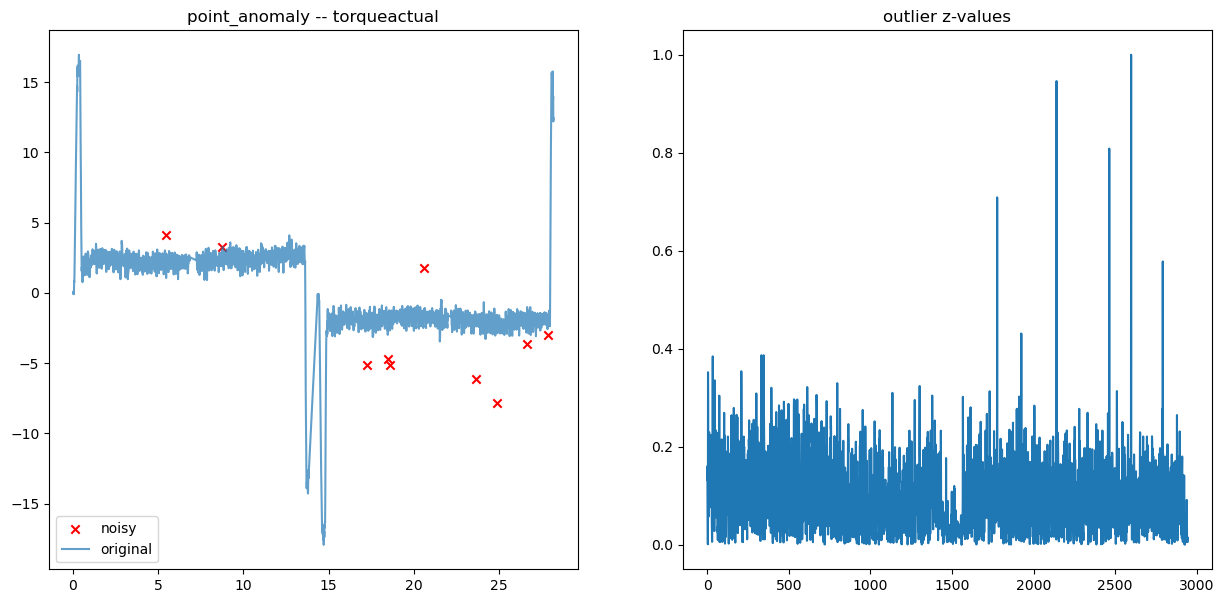

In [64]:
std = 2.0
num = 10

point_anomaly_data = NoiseMachine.point_anomaly(experiment_data, num=num, std=std)

# ----------------
anomaly_data_to_list = [sum(x) for x in zip(point_anomaly_data[param_name].tolist(), point_anomaly_data["noise"].tolist())]
temp_detect_list = detect_anomaly_via_z(robot_name, series_name, param_name, anomaly_data_to_list, dict_with_mean_and_std)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

plot_noise_normal(point_anomaly_data, axs[0])

axs[1].plot([n for n in range(len(temp_detect_list))], temp_detect_list)
axs[1].set_title("outlier z-values")

plt.show()

Size problem


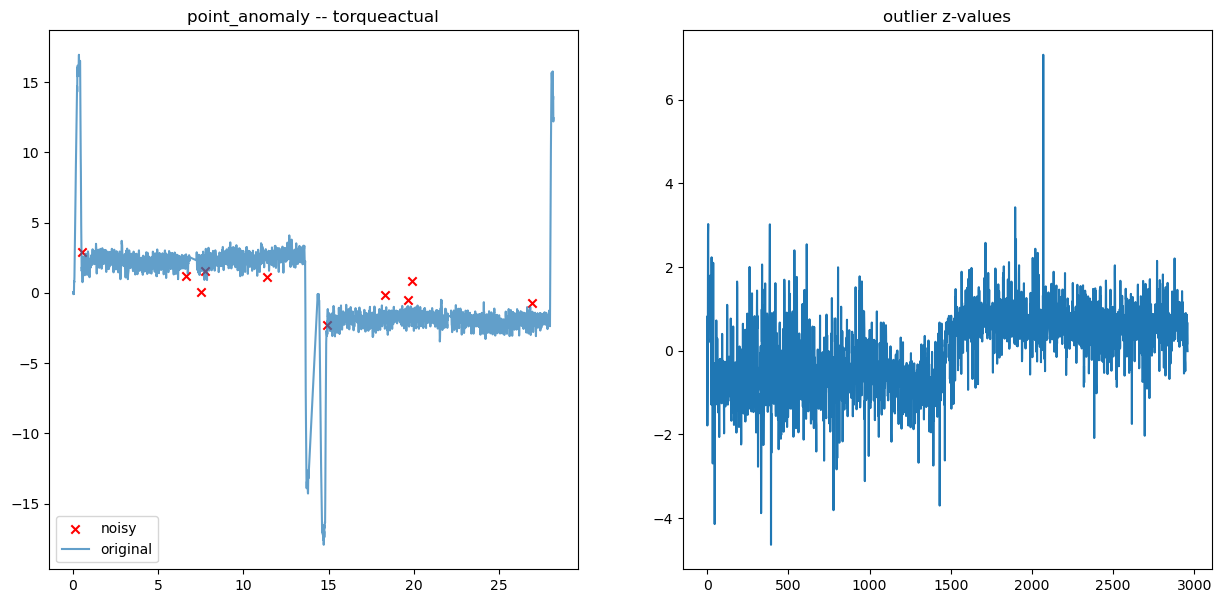

In [65]:
std = 2.0
num = 10

point_anomaly_data = NoiseMachine.point_anomaly(experiment_data, num=num, std=std)

# ----------------
anomaly_data_to_list = [sum(x) for x in zip(point_anomaly_data[param_name].tolist(), point_anomaly_data["noise"].tolist())]
temp_detect_list = detect_anomaly_via_z_MAD_specific(modified_df, robot_name, series_name, param_name, anomaly_data_to_list)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

plot_noise_normal(point_anomaly_data, axs[0])

axs[1].plot([n for n in range(len(temp_detect_list))], temp_detect_list)
axs[1].set_title("outlier z-values")

plt.show()

#### 1.2 Gaussian Noise Anomalies

ERROR: The size of the data is not equal to the saved mean/std data
The size of the data:  2960
The size of the saved mean:  3024


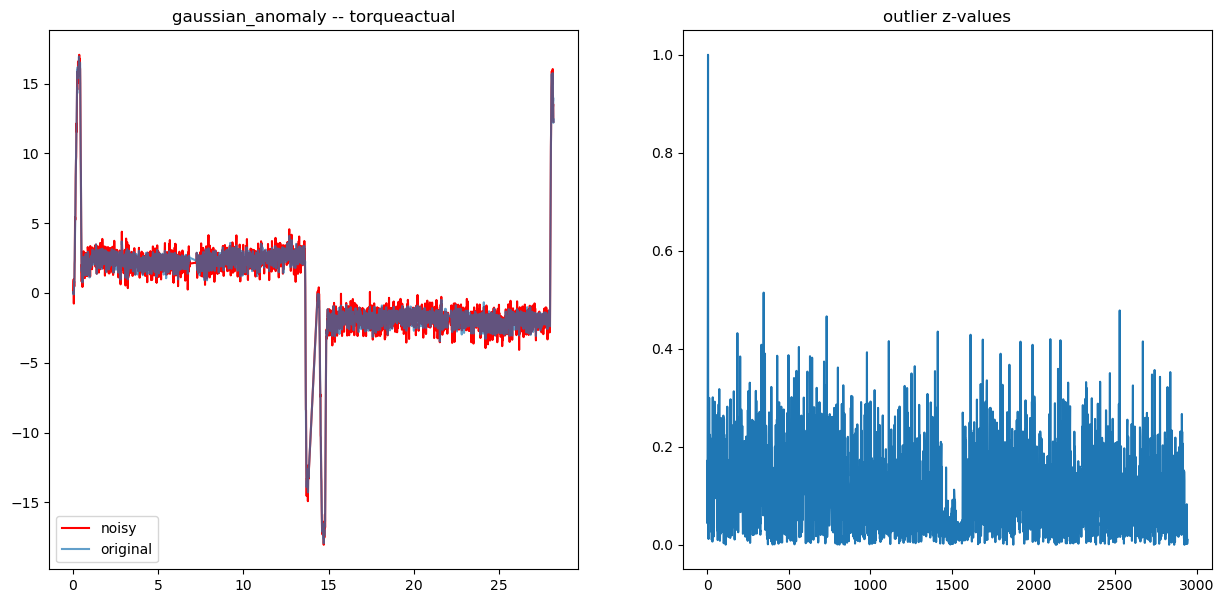

In [63]:
std = 0.4
gauss_anomaly_data = NoiseMachine.gaussian_anomaly(experiment_data, std=std)

# -----------
anomaly_data_to_list = [sum(x) for x in zip(gauss_anomaly_data[param_name].tolist(), gauss_anomaly_data["noise"].tolist())]
temp_detect_list = detect_anomaly_via_z(robot_name, series_name, param_name, anomaly_data_to_list, dict_with_mean_and_std)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

plot_noise_normal(gauss_anomaly_data, axs[0])

axs[1].plot([n for n in range(len(temp_detect_list))], temp_detect_list)
axs[1].set_title("outlier z-values")

plt.show()

#### 1.3 Shift Noise Anomalies

Size problem


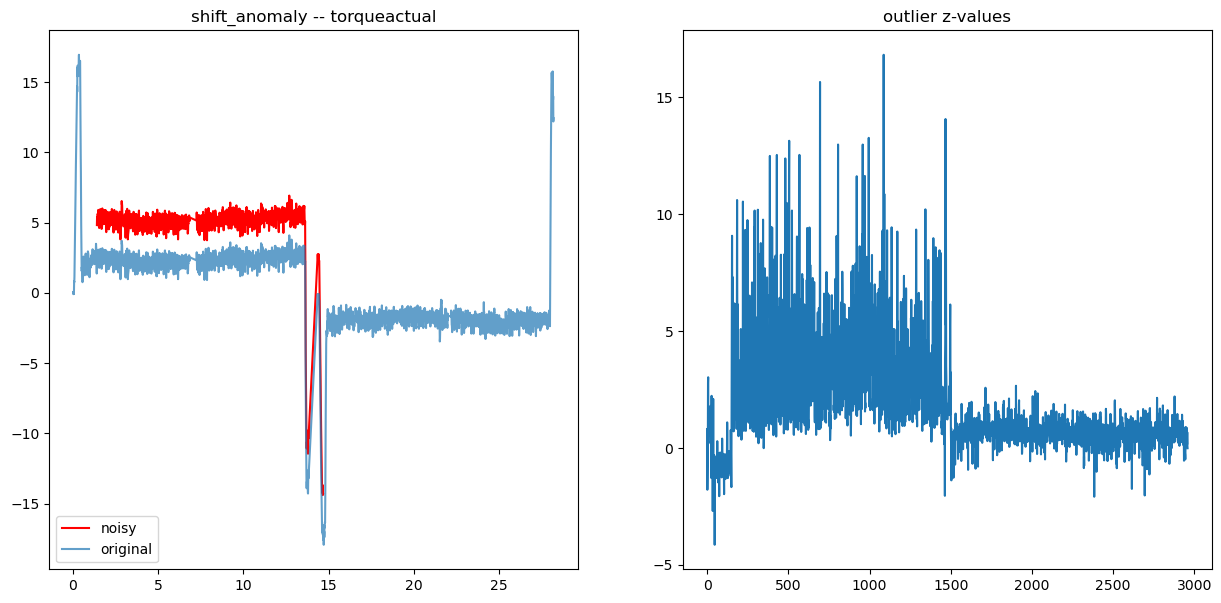

In [51]:
start = 150
end = 1500
strength = 2
length = end - start

shift_anomaly_data = NoiseMachine.shift_anomaly(
    experiment_data,
    start=start,
    length=length,
    strength=strength,
)

# -----------
anomaly_data_to_list = [sum(x) for x in zip(shift_anomaly_data[param_name].tolist(), shift_anomaly_data["noise"].tolist())]

temp_detect_list = baseline_model_ref.get_anomaly_list_modified_z_scores(modified_df, robot_name, series_name, param_name, anomaly_data_to_list) 

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

plot_noise_normal(shift_anomaly_data, axs[0])

axs[1].plot([n for n in range(len(temp_detect_list))], temp_detect_list)
axs[1].set_title("outlier z-values")

plt.show()

#### 1.4 Trend Noise Anomaly

C:\Users\dnaen\PycharmProjects\anomaly_detection\src\data\anomalies.py:164: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


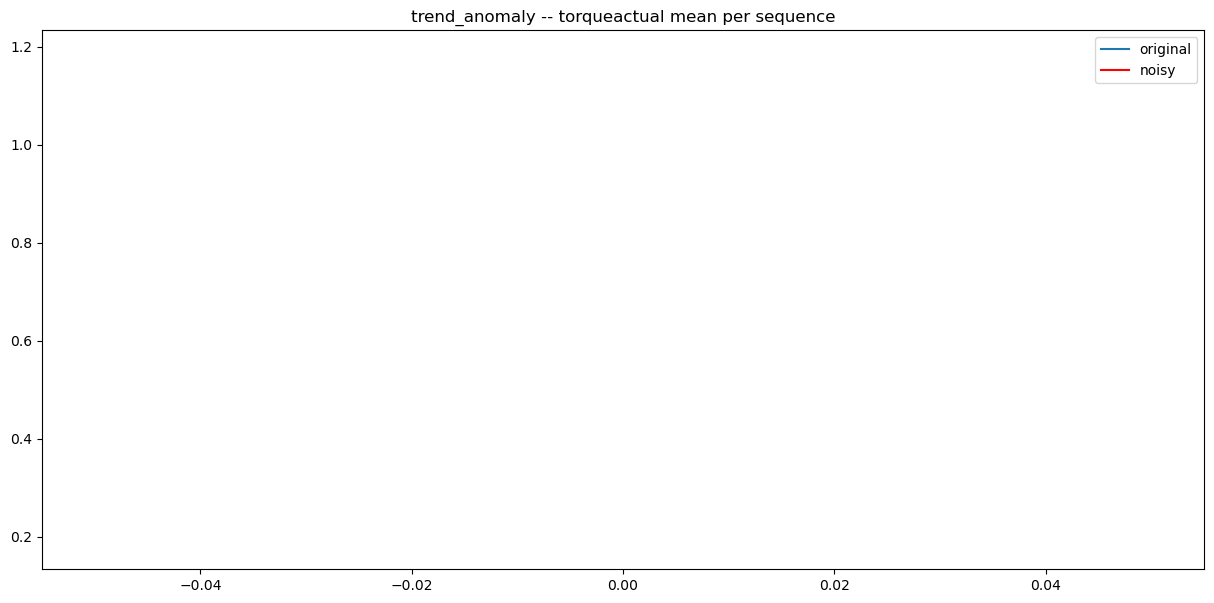

In [67]:
experiment_data_copy = experiment_data.copy(deep=True)

experiment_data_copy["type"] = experiment_data_copy["id"].apply(lambda x: x.split("-")[1].split("|")[0])
experiment_data_copy["datetime"] = experiment_data_copy["id"].apply(lambda x: x.split("|")[1].replace("_", " "))
experiment_data_copy["datetime"] = pd.to_datetime(experiment_data_copy["datetime"])
experiment_data_copy = experiment_data_copy[experiment_data_copy["type"] == "100440"]
experiment_data_copy = experiment_data_copy.sort_values(by=["datetime", "timeindex"])
experiment_data_copy = experiment_data_copy.reset_index(drop=True)

max_shift = 2

data_440 = NoiseMachine.trend_anomaly(experiment_data_copy, max_shift=max_shift)
NoiseMachine.plot(data_440, column="torqueactual")

In [ ]:
# trying to add coloured

# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# 
# diff_of_probs = [abs(prob_list_of_correct_size_25[i] - prob_list_of_anomaly_size_25[i]) for i in range(len(prob_list_of_correct_size_25))]
# 
# # Normalize y values to range [0, 1] for the colormap
# norm = Normalize(vmin=min(diff_of_probs), vmax=max(diff_of_probs))
# cmap = plt.get_cmap('viridis')  # Choose a colormap
# colors = cmap(norm(diff_of_probs))
# colors = np.delete(colors, 3, axis=1)
# 
# plt.plot([n for n in range(len(diff_of_probs))], diff_of_probs, marker = 'o', c = colors[0], markersize = 5, cmap='RdYlGn')
# plt.xlabel('index')
# plt.ylabel("prob")
# plt.show()

In [ ]:
# dynamically plot

# import matplotlib.pyplot as plt
# import random
#  
# plt.ion()  # turning interactive mode on
# 
# # preparing the data
# y = [diff_of_probs[0]]
# x = [1]
#  
# # plotting the first frame
# plt.plot(x,y)[0]
# plt.ylim(0,10)
# plt.show()
# plt.pause(1)
#  
# # the update loop
# i=1
# while i < len(diff_of_probs):
#     i+=1
#     # updating the data
#     y.append(diff_of_probs[i])
#     x.append(x[-1]+1)
#      
#     # removing the older graph
#     # graph.remove()
#     plt.clf()
#     # graph.clear()
#     # plt.close(graph)
#     # plt.close(graph)
#      
#     # plotting newer graph
#     plt.plot(x,y,color = 'g')[0]
#     plt.xlim(x[0], x[-1])
#     plt.show()
#     
#     # calling pause function for 0.25 seconds
#     plt.pause(0.25)

In [ ]:
# TEMP TRASH
#
#
#
# len(modified_df[(modified_df['id'] == '6640-102123|2021-05-18_08:52:44') & (modified_df["type"] == "TL")]["timeindex"])
# 
#     # go through each robot id
#     for specific_robot_id in all_specific_robot_ids[:2]:
#         print("Current robot id: ", specific_robot_id)
#         print()
#         time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if specific_robot_id in time_index]
#         
#         # new_df[(new_df['id'] == time_index_ids_of_specific_robot)
#         # now accessing all info of that robot
#         # Here need to remember that: "TL" does not have "torque feedforward" as a variable. 
#        
#         
#         for series_type in all_series_type:
#             for param_type in all_parameter_type:
#                 temp_sub_df = pd.DataFrame()
#                 # add the time_indexes here
#                 for t_index in time_index_ids_of_specific_robot:
#                     temp_sub_df[t_index] = new_df[(new_df['id'] == t_index) & (new_df["type"] == series_type)][param_type]
#                 
#                 for t_index in time_index_ids_of_specific_robot:
#                     new_df.loc[(new_df['id'] == t_index) & (new_df["type"] == series_type), param_type + "_mean"] = temp_sub_df.mean(axis = 1)
#                     
#                     new_df.loc[(new_df['id'] == t_index) & (new_df["type"] == series_type), param_type + "_std"] = temp_sub_df.std(axis = 1)
#                     
#     return new_df 
    
# --------------------------

# because their time-indexes are different
    # time_indexes_dict = {}
    # for series_type in all_series_type:
    #     time_indexes_dict[series_type] = list(new_df.loc[(new_df["type"] == series_type), "timeindex"].unique())
    #         
    
# --------------------------

# for specific_robot_id in all_specific_robot_ids[:2]:
#         print("Current robot id: ", specific_robot_id)
#         print()
#         time_index_ids_of_specific_robot = [time_index for time_index in all_time_index_ids if specific_robot_id in time_index]
#         
#         # because their time-indexes are different
#         # time_indexes_dict = {}
#         # for series_type in all_series_type:
#         #     time_indexes_dict[series_type] = list(new_df.loc[(new_df['id'].isin(time_index_ids_of_specific_robot)) & (new_df["type"] == series_type), "timeindex"].unique())
#         #     
#         # new_df[(new_df['id'] == time_index_ids_of_specific_robot)
#         # now accessing all info of that robot
#         # Here need to remember that: "TL" does not have "torque feedforward" as a variable. 
#         # TODO: figure out what to do for "not equal number of time_indexes"
#         print(time_indexes_dict)
#         print(time_indexes_dict.get("Ta").sort())
#         for series_type in all_series_type:
#             temp_sub_df = pd.DataFrame(time_indexes_dict.get(series_type).sort())
#             print(temp_sub_df.head(5))
#             
#         for t_index in time_index_ids_of_specific_robot:
#             for time in list(new_df.loc[(new_df['id'] == t_index), "timeindex"]):
#                 temp_sub_df = temp_sub_df.append(time, ignore_index=True)
#                 # temp_sub_df.loc[len(temp_sub_df.index)] = time
#                 
#         print(temp_sub_df["id"])
#         for time in list(temp_sub_df["id"]):
#             for series_type in all_series_type:
#                 for param_type in all_parameter_type:
#                     for t_index in time_index_ids_of_specific_robot:
#                         # if series_type + "_" + param_type not in temp_sub_df.columns: temp_sub_df[]
#                         temp_sub_df.loc[temp_sub_df["id" == time], series_type + "_" + param_type] = new_df[(new_df['id'] == t_index) & (new_df["type"] == series_type)][param_type]
#                         
#         print(temp_sub_df.head())
#                     
#     return new_df 
    
# ------------------------------

# temp_sub_df = pd.DataFrame(time_indexes_dict.get(series_type), columns=["id"]) # TODO: Add some sort here?
#             
#             for time in list(temp_sub_df["id"]):
#                 for param_type in all_parameter_type:
#                     for t_index in time_index_ids_of_specific_robot:
#                         # if series_type + "_" + param_type not in temp_sub_df.columns: temp_sub_df[series_type + "_" + param_type] = np.nan
#                         temp_sub_df.loc[temp_sub_df["id"] == time, series_type + "_" + param_type] = new_df[(new_df['id'] == t_index) & (new_df["type"] == series_type)][param_type]
#                             
#         print(temp_sub_df.head())

# def calculate_prob_list(given_robot_name, given_series_type, given_param, given_data, given_mean_and_std_info):
#     
#     prob_list = []
#     saved_mean = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_avg")
#     saved_std = given_mean_and_std_info.get(given_robot_name + "_" + given_series_type + "_" + given_param + "_std")
#     
#     # print("Len of data: ", len(given_data))
#     # print("Len of avg: ", len(saved_mean))
#     # print("Len of std: ", len(saved_std))
#     error_count = 0
#     for i in range(len(given_data)):
#         try:
#             z = (np.abs(given_data[i] - saved_mean[i])) / saved_std[i]
#             p_value = st.norm.sf(abs(z))*2 # 2-sided test
#             # p_value = st.norm.cdf(z) # gives the percentage
#             prob_list.append(p_value) # TODO: add additional check for 0 and so on?
#             # print("Given data: ", given_data[i])
#             # print("Saved mean: ", saved_mean[i])
#             # print("Saved std: ", saved_std[i])
#             # print("The z value: ", z)
#             # print("The p value: ", p_value)
#             # print()
#     
#         except Exception as e:
#             print(Exception)
#             error_count += 1
#             # print("Probably key error: ", e)
#             # print("Something wrong with size") 
#             # "Ta"'s time_size is 6912 (but can change very little)
#             # "Tl"'s time_size is 2986 (but can change very little)
#         
#     print("Error count: ", error_count)
#     # np.nanmean(prob_list)
#     return prob_list

In [ ]:
# # original data
# sub_modified_df = utils.get_time_series(modified_df, 0)
# 
# # anomaly data
# copy_sub_modified_df = sub_modified_df.copy(deep=True)
# percentage_of_anomaly = int(len(copy_sub_modified_df) / 2)  # modifying 20% of the data
# modified_df_with_anomaly = utils.inject_point_anomaly(copy_sub_modified_df, 1.1, percentage_of_anomaly)
# a = list(sub_modified_df["torqueactual"])
# b = list(modified_df_with_anomaly["torqueactual"])
# 
# plt.plot([n for n in range(len(a))], a)
# plt.plot([n for n in range(len(b))], b)
# 
# plt.xlabel('time-index')
# plt.ylabel("7600-100440")
# plt.show()
# # choosing one of them to compare
# get_all_robots_of_specific_id_sessions(modified_df, '7600-100440', "Ta")
# # params: "torqueactual", "torquefeedforward" -> but anomaly only works in "torqueactual"
# # params: "Ta", "Tl"
# 
# # Testing
# robot_name = "7600-100498"
# series_name = "Ta"
# param_name = "torqueactual"
# 
# # id_name = "7600-100440|2022-11-16_09:42:54"
# # temp_data_correct = list(modified_df[(modified_df['id'] == id_name) & (modified_df["type"] == series_name)][param_name])
# # temp_data_anomaly = list(modified_df_with_anomaly[(modified_df_with_anomaly['id'] == id_name) & (modified_df_with_anomaly["type"] == series_name)][param_name])
# 
# temp_data_correct = list(sub_modified_df[param_name])
# temp_data_anomaly = list(modified_df_with_anomaly[param_name])
# # 
# # prob_list_of_correct = calculate_prob_list(robot_name, series_name, param_name, temp_data_correct, dict_with_mean_and_std)
# # prob_list_of_anomaly = calculate_prob_list(robot_name, series_name, param_name, temp_data_anomaly, dict_with_mean_and_std)
# 
# # print("The prob. result of with the correct df: ", np.nanmean(prob_list_of_correct))
# # print("The prob. result of with the anomaly df: ", np.nanmean(prob_list_of_anomaly))
# temp_detect_list = detect_anomaly_via_z(robot_name, series_name, param_name, temp_data_anomaly, dict_with_mean_and_std)
# plt.plot([n for n in range(len(temp_detect_list))], temp_detect_list)
# plt.xlabel('index')
# plt.ylabel("prob")
# plt.show()
# temp_detect_list_size_25 = compress_a_list_of_integers(temp_detect_list, 25)  # reducing to size N
# 
# plt.plot([n for n in range(len(temp_detect_list_size_25))], temp_detect_list_size_25)
# plt.xlabel('index')
# plt.ylabel("prob")
# plt.show()
# # prob_list_of_anomaly_size_25 = compress_a_list_of_integers(prob_list_of_anomaly, 25) # reducing to size N
# # check how it compares between our saved mean/std and anomaly data
# temp_saved_mean = dict_with_mean_and_std.get(robot_name + "_" + series_name + "_" + param_name + "_avg")
# temp_saved_std = dict_with_mean_and_std.get(robot_name + "_" + series_name + "_" + series_name + "_std")
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(15)
# fig.suptitle('Plot')
# ax1.errorbar([n for n in range(len(temp_saved_mean))], temp_saved_mean, yerr=temp_saved_std, fmt='o', markersize=1)
# ax1.plot([n for n in range(len(temp_data_anomaly))], temp_data_anomaly)
# ax1.set_title("saved mean data vs. anomaly data")
# 
# ax2.plot([n for n in range(len(temp_detect_list))], temp_detect_list)
# ax2.set_title("outlier z-values")
# plt.show()